In [1]:
import sys
sys.path.append('/data/home/kseorang/Deep-Learning-Study')

import torch
from model import Model
from torchvision import transforms, datasets
import torch.nn as nn

from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.0.1+cu117  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

train_dataset = datasets.CIFAR10(root = "./data/",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "./data/",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

print(train_loader.dataset)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [43252 30249 26626 17560]


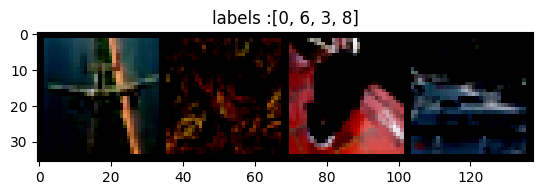

In [4]:
# 이미지 확인용
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

grid_size = 4
rnd_inds = np.random.randint(0, len(train_dataset), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_dataset[i][0] for i in rnd_inds]
y_grid = [train_dataset[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [5]:
model = Model().resnet18().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [7]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    scheduler.step(metrics=test_loss)  
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.421043
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 3.140870
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.341465
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.211523
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 2.295421
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 2.430765
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.179266
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.272415
[EPOCH: 1], 	Test Loss: 2.1641, 	Test Accuracy: 17.32 %

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 2.114130
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 2.035080
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 2.279612
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.118313
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 2.193916
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.937390
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.046656
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 2.153661
[EPOCH: 2], 	Test Loss: 2.0922, 	Test Accuracy: 19.99 %

Tr